In [2]:
import os
from collections import OrderedDict,Counter
from __future__ import division
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
%matplotlib inline

In [3]:
#I made these files in 6_pca.ipynb, they are symlinked to the hierfstat folder
#genotypes are coded based on minor allele
hierf = '/home/lindb/wbp/hierfstat/missing/missing_z12_maf_swp_trans.txt'

In [4]:
hierfdf = pd.read_csv(hierf,header=0,index_col=0,sep="\t")

In [5]:
hierfdf.head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,NaN,11,11,11,11,12,11,...,11,11,NaN,11,12,12,11,11,11,NaN
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,NaN,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,12,11,12,11,11,12,11,...,11,11,12,11,NaN,11,12,11,11,12


In [6]:
hierfdf.to_csv('/home/lindb/wbp/hierfstat/missing/missing_z12_maf_swp_trans_NOIDX.txt',header=True,index=False,sep="\t")

# Put into R

```R

setwd("/home/lindb/wbp/hierfstat/missing/")
get_varcomp = function(x) 
{
    library(hierfstat)
    loci = data.frame(x)
    res <- varcomp(cbind(levels, loci),diploid=T)$overall
}

finish_varcomp = function(m) 
{
    tot <- apply(m, 2, sum, na.rm = TRUE)
    nblevels <- length(tot)
    f <- matrix(rep(0, (nblevels - 1)^2), ncol = (nblevels - 1))
    for (i in 1:(nblevels - 1)) 
    {
        for (j in i:(nblevels - 1)) 
        {
            f[i, j] <- sum(tot[i:j])/sum(tot[i:nblevels])
        }
    }
    row.names(m) <- lnames
    print(names(tot))
    tf <- t(f)
    row.names(tf) <- fnames
    f <- t(tf)
    row.names(f) <- c("Total", fnames[-length(fnames)])
    return(list(loc = m, overall = tot, F = f))
}


library(hierfstat)
library(data.table)
library(snow)
data = data.frame(fread("missing_z12_maf_swp_trans_NOIDX.txt", header=T, sep="\t"))
levels = data.frame(data[,1:2])
loci = data[,3:ncol(data)]
lnames=names(loci)
fnames=c(names(levels), "Ind")
cl = makeSOCKcluster(50)
clusterExport(cl, "levels", envir=environment())
system.time(res <- matrix(parCapply(cl, loci, get_varcomp), nrow=length(names(loci)),byrow=T))
res = finish_varcomp(res)
saveRDS(res, "hierfstatRUN_missing.rds")
system.time(bs <- basic.stats(data))
saveRDS(bs, "bs_hierfstatRUN_missing.rds")
stopCluster(cl)
print("Done!")


```

In [7]:
def setup_r(): 
    os.environ['R_HOME'] = '/home/lindb/g/R3/lib64/R/' 
    os.environ['LD_LIBRARY_PATH'] = "%s/lib:%s" % (os.environ['R_HOME'], 
                                                   os.environ['LD_LIBRARY_PATH'])

In [8]:
setup_r()
import readline
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri as pd2ri
pd2ri.activate()
r = robjects.r

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython
%matplotlib inline

In [10]:
%%R
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


In [11]:
def get_r_series(key):
    s = pd.Series(get_r(key))
    s.index = get_r("names(%s)" % key)
    return s

def get_r_df(key):
    df = pd.DataFrame(get_r(key))
    try:
        rname = get_r("rownames(%s)" % key)
        df.index = rname
    except:
        pass
    
    try:
        cname = get_r("colnames(%s)" % key)
        df.columns = cname
    except:
        pass
    
    return df

def get_r(key):
    return r(key)

In [12]:
%%R
res = readRDS("/home/lindb/wbp/hierfstat/missing/hierfstatRUN_missing.rds")

In [13]:
resF = get_r_df("res$F")
resF

,popid,plotid,Ind
Total,0.004442,0.007940,-0.100050
popid,0.000000,0.003514,-0.104957
plotid,0.000000,0.000000,-0.108854


In [14]:
overall = get_r_df("res$overall")
overall

,0
0,130.936685
1,103.124602
2,-3183.546095
3,32429.685176


In [15]:
loc = get_r_df("res$loc")
loc.head()

,0,1,2,3
NODE_1000013_length_91_cov_1.802198_37,0.005071,-0.015490,0.135857,0.171598
NODE_1000031_length_98_cov_2.000000_30,-0.001182,-0.003903,-0.033064,0.277419
NODE_1000037_length_93_cov_2.043011_33,-0.000462,-0.005312,-0.036442,0.291667
NODE_1000042_length_93_cov_1.118280_100,-0.003369,-0.000120,-0.012285,0.178295
NODE_1000053_length_94_cov_1.744681_25,-0.001228,0.001638,-0.001841,0.054187


In [16]:
def compute_F_plotTotal(series):
    Hs = series[0]+series[1]
    Ht = sum(series)
    return Hs/Ht

In [17]:
plot_total_fst = loc.apply(compute_F_plotTotal, axis=1)
plot_total_fst.shape,plot_total_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37    -0.035077
 NODE_1000031_length_98_cov_2.000000_30    -0.021254
 NODE_1000037_length_93_cov_2.043011_33    -0.023150
 NODE_1000042_length_93_cov_1.118280_100   -0.021468
 NODE_1000053_length_94_cov_1.744681_25     0.007779
 dtype: float64)

<a list of 29 Patch objects>

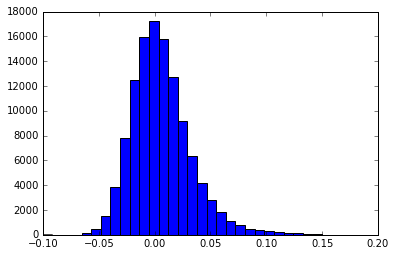

In [18]:
plt.hist(plot_total_fst, bins = [x for x in np.linspace(-0.1,0.15,30)])[2]

In [19]:
def compute_F_popTotal(series):
    return series[0]/sum(series)

In [20]:
pop_total_fst = loc.apply(compute_F_popTotal, axis = 1)
pop_total_fst.shape,pop_total_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37     0.017072
 NODE_1000031_length_98_cov_2.000000_30    -0.004942
 NODE_1000037_length_93_cov_2.043011_33    -0.001854
 NODE_1000042_length_93_cov_1.118280_100   -0.020731
 NODE_1000053_length_94_cov_1.744681_25    -0.023275
 dtype: float64)

<a list of 29 Patch objects>

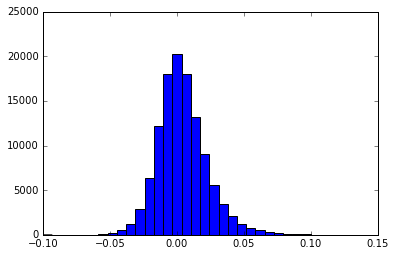

In [21]:
plt.hist(pop_total_fst, bins = [x for x in np.linspace(-0.1,0.1,30)])[2]

In [22]:
def compute_F_plotPop(series):
    return series[1]/sum(series[1:])

In [23]:
plot_pop_fst = loc.apply(compute_F_plotPop,axis=1)
plot_pop_fst.shape,plot_pop_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37    -0.053055
 NODE_1000031_length_98_cov_2.000000_30    -0.016232
 NODE_1000037_length_93_cov_2.043011_33    -0.021257
 NODE_1000042_length_93_cov_1.118280_100   -0.000722
 NODE_1000053_length_94_cov_1.744681_25     0.030348
 dtype: float64)

<a list of 29 Patch objects>

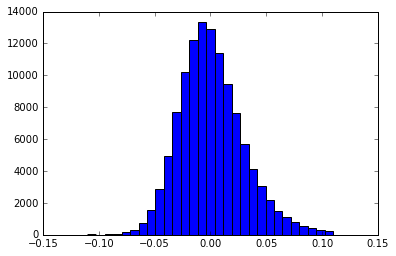

In [24]:
plt.hist(plot_pop_fst, bins = [x for x in np.linspace(-0.11,0.11,30)])[2]

In [25]:
dfs = [pop_total_fst,plot_total_fst,plot_pop_fst]
ds = ["pop_total","plot_total","plot_pop"]
for i,d in enumerate(dfs):
    d = pd.DataFrame(d)
    d.columns = [ds[i]]
    if i == 0:
        df = pd.DataFrame(d)
    else:
        df = pd.merge(df,d,left_index=True,right_index=True)
df.head()

,pop_total,plot_total,plot_pop
NODE_1000013_length_91_cov_1.802198_37,0.017072,-0.035077,-0.053055
NODE_1000031_length_98_cov_2.000000_30,-0.004942,-0.021254,-0.016232
NODE_1000037_length_93_cov_2.043011_33,-0.001854,-0.023150,-0.021257
NODE_1000042_length_93_cov_1.118280_100,-0.020731,-0.021468,-0.000722
NODE_1000053_length_94_cov_1.744681_25,-0.023275,0.007779,0.030348


In [27]:
locDict = OrderedDict()
j = 0
for i,SNP in enumerate(hierfdf.columns[2:]):
    l = len([x for x in hierfdf.loc[:,SNP] if x > 0])
    pthere = l/len(hierfdf.index)
    locDict[SNP] = pthere
    j+=1
    if j % 1000 == 0:
        print j

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [28]:
perc = pd.DataFrame()
perc[0] = locDict.values()
perc.index = locDict.keys()
perc.columns = ['perc data']
perc.head()

,perc data
NODE_1000013_length_91_cov_1.802198_37,0.692623
NODE_1000031_length_98_cov_2.000000_30,0.635246
NODE_1000037_length_93_cov_2.043011_33,0.688525
NODE_1000042_length_93_cov_1.118280_100,0.528689
NODE_1000053_length_94_cov_1.744681_25,0.831967


In [29]:
perc.shape

(116231, 1)

In [30]:
df = pd.merge(df,perc,left_index=True,right_index=True)
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,0.017072,-0.035077,-0.053055,0.692623
NODE_1000031_length_98_cov_2.000000_30,-0.004942,-0.021254,-0.016232,0.635246
NODE_1000037_length_93_cov_2.043011_33,-0.001854,-0.023150,-0.021257,0.688525
NODE_1000042_length_93_cov_1.118280_100,-0.020731,-0.021468,-0.000722,0.528689
NODE_1000053_length_94_cov_1.744681_25,-0.023275,0.007779,0.030348,0.831967


In [31]:
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,0.017072,-0.035077,-0.053055,0.692623
NODE_1000031_length_98_cov_2.000000_30,-0.004942,-0.021254,-0.016232,0.635246
NODE_1000037_length_93_cov_2.043011_33,-0.001854,-0.023150,-0.021257,0.688525
NODE_1000042_length_93_cov_1.118280_100,-0.020731,-0.021468,-0.000722,0.528689
NODE_1000053_length_94_cov_1.744681_25,-0.023275,0.007779,0.030348,0.831967


In [32]:
filE = '/home/lindb/wbp/hierfstat/missing/missing_hierarchical_Fstats.txt'
df.to_csv(filE, header=True,index=True,sep="\t")

In [33]:
min(df['perc data']),max(df['perc data'])

(0.5, 0.91393442622950816)